In [1]:
import cv2
import time
import numpy as np
import pandas as pd
from PIL import Image
from selenium import webdriver
from matplotlib import pyplot as plt
from keras.models import load_model
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#load model
le = joblib.load('./model/label_encoder_cnn_rnn')['le']
model = load_model('./model/model_cnn_rnn.h5')

#set url & webdriver
url = 'http://railway1.hinet.net/Foreign/TW/ecsearch.html'
driver = webdriver.PhantomJS('./phantomjs-2.1.1-macosx/bin/phantomjs')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


In [3]:
def preprocess_img(img, l = 35, r = 500, w = 200, h = 60):
    crop_img = Image.fromarray(img[r:r+h, l:l+w])
    crop_img_L = crop_img.convert("L")
    data_img = np.stack([np.array(crop_img_L).transpose()/255.0])
    data_img = data_img.reshape(data_img.shape+(1,))
    
    return data_img, crop_img

def pred_num(data_img, model, le):
    scores = model.predict(data_img)[0]
    num =  ''.join(le.inverse_transform([np.argmax(score) for score in scores]))
    num = num.replace('#', '')
    return num

## 上網實測1000筆，並觀察錯誤的驗證碼

pred_num: 38600


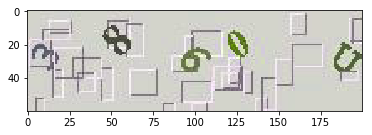

pred_num: 95K92


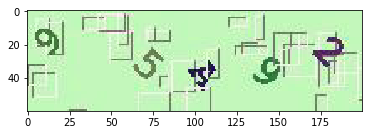

pred_num: G6900


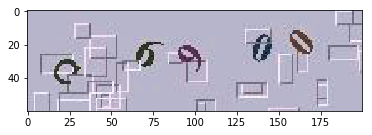

pred_num: 045058


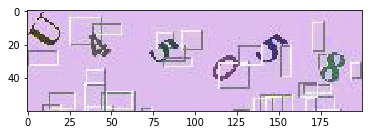

pred_num: 90092


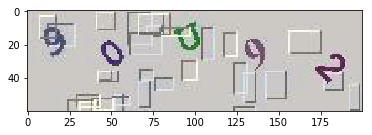

pred_num: 06100


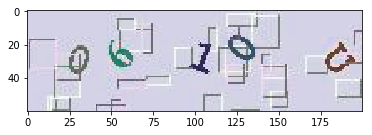

pred_num: 93551


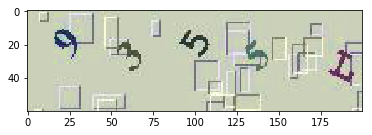

pred_num: 3F6403


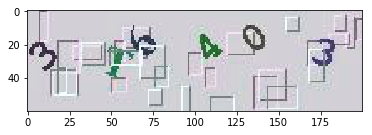

pred_num: 03S080


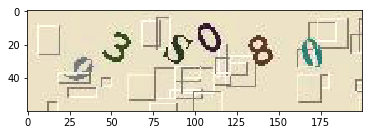

In [4]:
result = []
for _ in range(1000):
    driver.get(url)
    driver.find_element_by_id('person_id').send_keys('F111111111')
    driver.find_element_by_css_selector(".btn.btn-primary").click()
    driver.save_screenshot('temp.png')
     
    data_img, crop_img = preprocess_img(img = cv2.imread("temp.png"))
    num = pred_num(data_img, model, le)
    
    driver.find_element_by_id('randInput').send_keys(num)
    driver.find_element_by_css_selector(".btn.btn-primary").click()
    #印出預測錯的驗證碼
    if "亂數號碼錯誤" in driver.page_source:
        result.append(0)
        print('pred_num:', num) 
        plt.imshow(crop_img)
        plt.show()
    else:
        result.append(1)
    time.sleep(3)

## 觀察
1. 0和U最容易混淆，可針對這部分加強學習
2. 即使2個字靠很近也能辨識，例如最後一張的S0

## 測試準確率

In [6]:
np.array(result).mean()

0.991